In [5]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# ticker_list = ['FPTVN19', 'GASVN11', 'HPG19', 'MSN11', 'MWG19', 'VCB19', 'VHM19', 'VNM19']
ticker_list = ['FPTVN11', 'GASVN11', 'HPG19', 'MSN11', 'MWG11', 'VCB11', 'VHM19', 'VNM19']
underlying_list = ['FPT.VN', 'GAS.VN', 'HPG.VN', 'MSN.VN', 'MWG.VN', 'VCB.VN', 'VHM.VN', 'VNM.VN']

start_date = "2025-02-10"
end_date = "2026-02-10"

df_perf = pd.DataFrame()
for i, j in enumerate(underlying_list):
    ticker = ticker_list[i]
    ticker += ".BK"
    t = yf.Ticker(j)
    underlying_price = t.history(start=start_date, end=end_date, interval="1d")
    underlying_price["chg_pct"] = underlying_price['Close'].pct_change() * 100   
    ceiling = underlying_price[underlying_price['chg_pct'] >= 6].reset_index()
    
    for k in range(len(ceiling)):
        start_ceiling = ceiling.iloc[k,0]
        end_ceiling = ceiling.iloc[k,0] + pd.Timedelta(days=10) 
        try:
            ticker_range = yf.Ticker(ticker).history(start=start_ceiling, end=end_ceiling, interval="1d")
        except Exception:
            continue  
            
        # if not found data, just skip to next k
        if ticker_range is None or ticker_range.empty or len(ticker_range) < 2:
            continue
        if not {"Open", "Close"}.issubset(ticker_range.columns):
            continue

        day0_close = ticker_range["Close"].iloc[0]
        if pd.isna(day0_close) or day0_close == 0:
            continue            
            
        ticker_open_chg = (ticker_range["Open"].iloc[1] / ticker_range['Close'].iloc[0]) - 1
        ticker_close_chg = (ticker_range["Close"].iloc[1] / ticker_range['Close'].iloc[0]) - 1
        
        new_row = pd.DataFrame([{
            "ticker": ticker,
            "underlying": j,
            "ceiling_date": start_ceiling,
            "open_chg": ticker_open_chg,
            "close_chg": ticker_close_chg,
        }])
        df_perf = pd.concat([df_perf, new_row], ignore_index=True)
        
df_perf.head(5)

$FPTVN11.BK: possibly delisted; no price data found  (1d 2025-04-10 00:00:00+07:00 -> 2025-04-20 00:00:00+07:00) (Yahoo error = "Data doesn't exist for startDate = 1744218000, endDate = 1745082000")
$GASVN11.BK: possibly delisted; no price data found  (1d 2025-04-10 00:00:00+07:00 -> 2025-04-20 00:00:00+07:00) (Yahoo error = "Data doesn't exist for startDate = 1744218000, endDate = 1745082000")
$GASVN11.BK: possibly delisted; no price data found  (1d 2025-04-11 00:00:00+07:00 -> 2025-04-21 00:00:00+07:00) (Yahoo error = "Data doesn't exist for startDate = 1744304400, endDate = 1745168400")
$GASVN11.BK: possibly delisted; no price data found  (1d 2025-06-16 00:00:00+07:00 -> 2025-06-26 00:00:00+07:00) (Yahoo error = "Data doesn't exist for startDate = 1750006800, endDate = 1750870800")
$HPG19.BK: possibly delisted; no price data found  (1d 2025-04-10 00:00:00+07:00 -> 2025-04-20 00:00:00+07:00) (Yahoo error = "Data doesn't exist for startDate = 1744218000, endDate = 1745082000")
$HPG19.

,ticker,underlying,ceiling_date,open_chg,close_chg
0,FPTVN11.BK,FPT.VN,2025-10-21 00:00:00+07:00,0.025424,0.033898
1,FPTVN11.BK,FPT.VN,2026-01-16 00:00:00+07:00,-0.007752,-0.007752
2,GASVN11.BK,GAS.VN,2025-12-29 00:00:00+07:00,-0.011050,-0.011050
3,GASVN11.BK,GAS.VN,2026-01-05 00:00:00+07:00,-0.010471,0.026178
4,GASVN11.BK,GAS.VN,2026-01-06 00:00:00+07:00,0.040816,0.096939


C:\Users\JetnipatNipatkusolki\AppData\Local\Temp\ipykernel_21576\2140522697.py:173: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_ret_open = df_perf.groupby("ceiling_date").apply(
C:\Users\JetnipatNipatkusolki\AppData\Local\Temp\ipykernel_21576\2140522697.py:177: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_ret_close = df_perf.groupby("ceiling_date").apply(


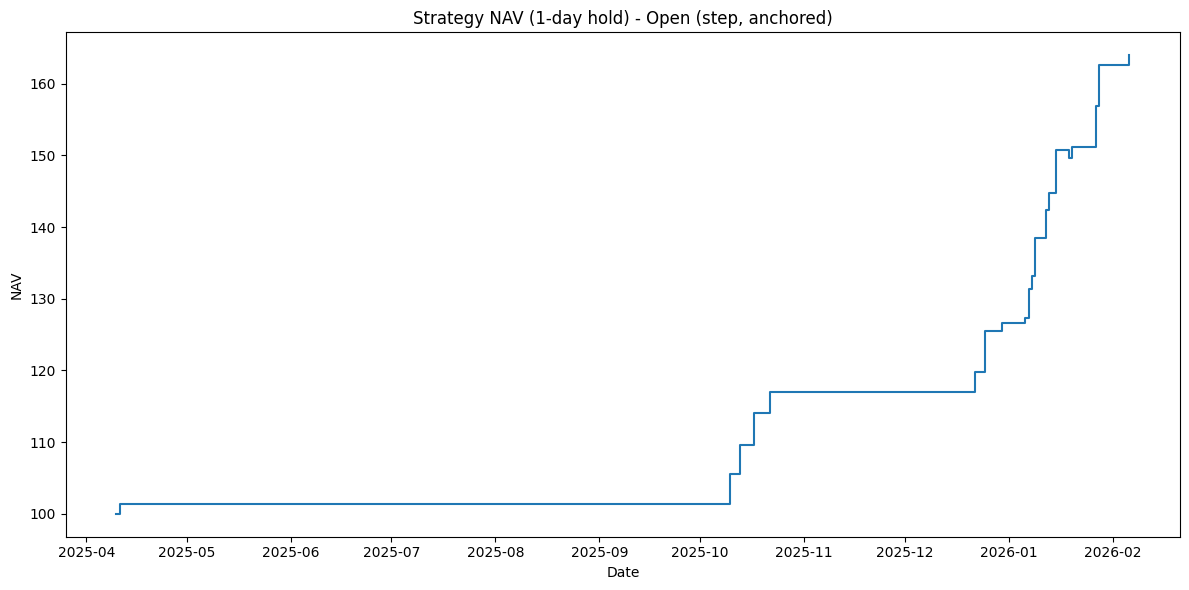

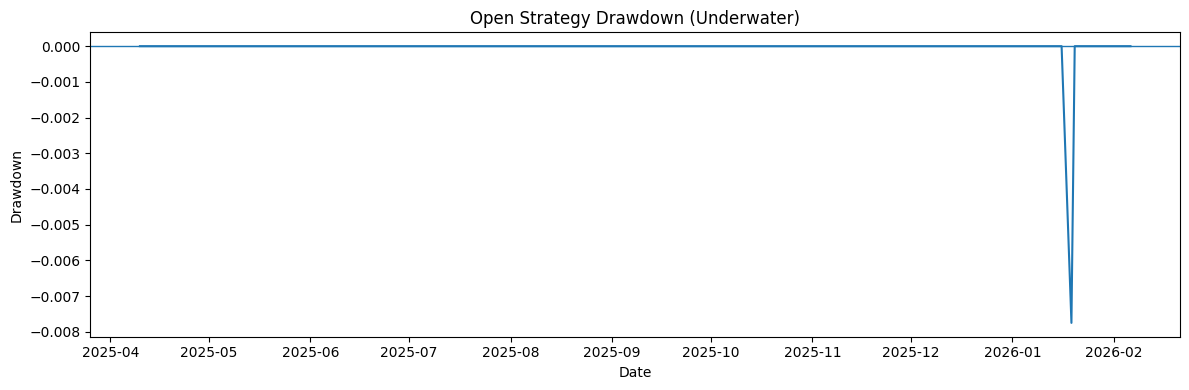

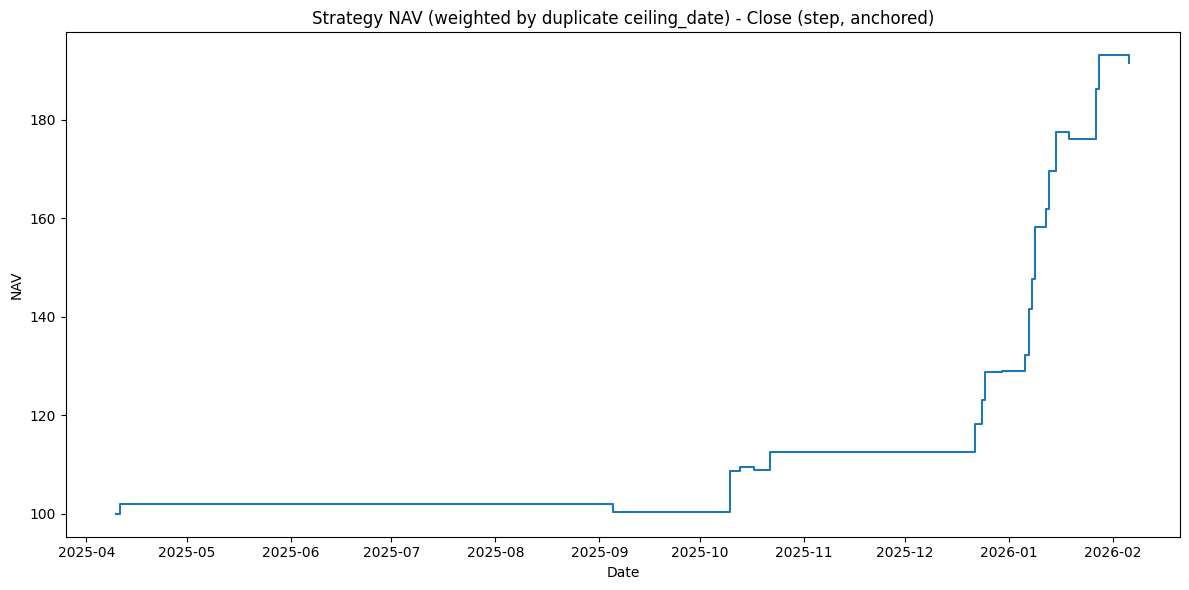

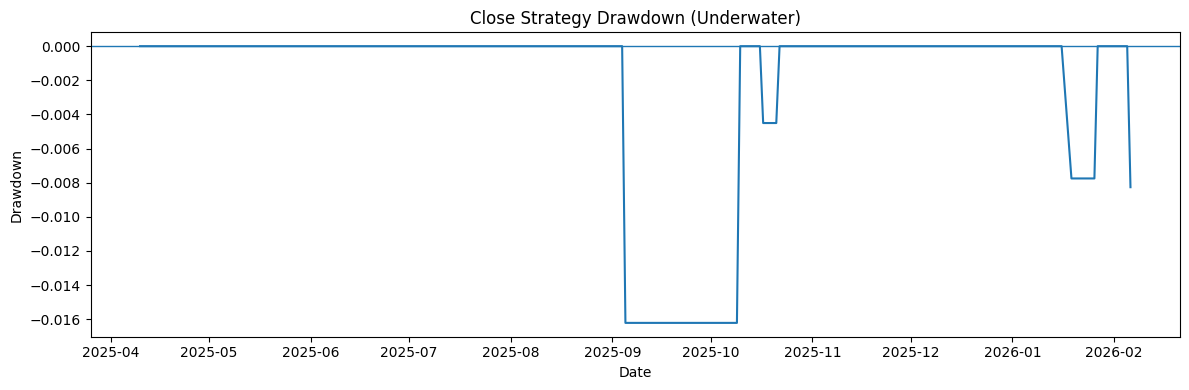

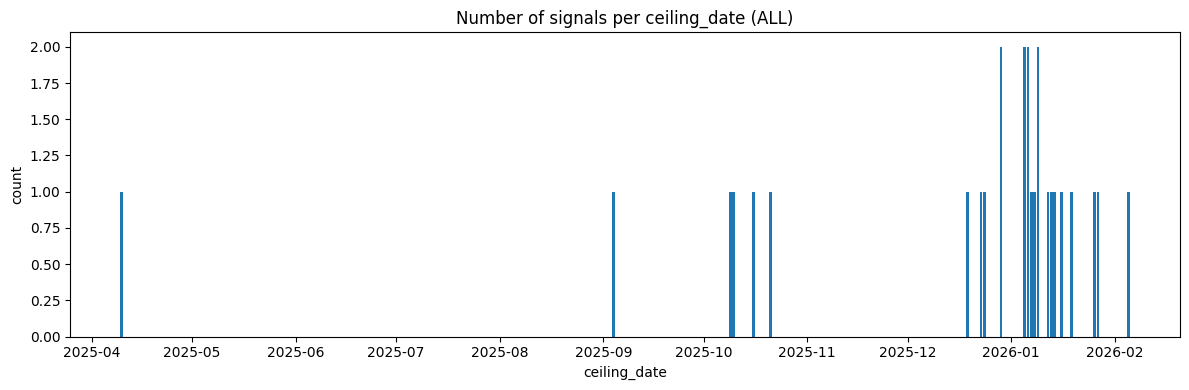


OPEN Strategy Metrics
Start              2025-04-10 00:00:00+07:00
End                2026-02-06 00:00:00+07:00
Num days (rets)                          216
Total return                        0.639875
CAGR                                0.780789
Ann. vol                             0.13711
Sharpe                              4.280173
Max drawdown                       -0.007752
Calmar                            100.721848
Win rate                            0.087963
Best day                             0.04698
Worst day                          -0.007752
dtype: object

CLOSE Strategy Metrics
Start              2025-04-10 00:00:00+07:00
End                2026-02-06 00:00:00+07:00
Num days (rets)                          216
Total return                        0.915183
CAGR                                1.134251
Ann. vol                            0.204239
Sharpe                              3.815426
Max drawdown                       -0.016216
Calmar                             69.9

In [6]:
# =========================
# SETTINGS
# =========================
START_NAV = 100.0
TRADING_DAYS = 252

# =========================
# HELPERS
# =========================
def nav_with_anchor_day(
    daily_ret: pd.Series,
    start_nav: float = 100.0,
    calendar: str = "B",  # "B" = business day; otherwise calendar day
) -> pd.Series:
    """
    Insert an anchor day one period BEFORE the first return date:
      NAV(anchor_date) = start_nav
    Then apply daily_ret on its original dates (no rescale, no editing returns).
    """
    daily_ret = daily_ret.dropna().copy().sort_index()
    if daily_ret.empty:
        return pd.Series(dtype=float)

    first_date = daily_ret.index[0]
    if calendar.upper() == "B":
        anchor_date = first_date - pd.offsets.BDay(1)
    else:
        anchor_date = first_date - pd.Timedelta(days=1)

    nav = (1.0 + daily_ret).cumprod() * start_nav
    nav.loc[anchor_date] = start_nav
    nav = nav.sort_index()
    return nav

def perf_metrics(daily_ret: pd.Series, nav: pd.Series, rf_annual: float = 0.0) -> pd.Series:
    """
    Metrics computed from daily returns; NAV used for drawdown.
    Expects daily_ret indexed by business days (or trading days you define).
    """
    daily_ret = daily_ret.dropna().copy().sort_index()
    if daily_ret.empty:
        return pd.Series(dtype=float)

    # Align NAV to returns dates (NAV may have an anchor day)
    nav_aligned = nav.reindex(daily_ret.index).dropna()
    daily_ret = daily_ret.reindex(nav_aligned.index)

    n = len(daily_ret)
    if n < 2:
        return pd.Series(dtype=float)

    # Return / CAGR
    total_return = (1.0 + daily_ret).prod() - 1.0
    cagr = (1.0 + total_return) ** (TRADING_DAYS / n) - 1.0

    # Vol / Sharpe
    ann_vol = daily_ret.std(ddof=1) * np.sqrt(TRADING_DAYS)
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    excess = daily_ret - rf_daily
    sharpe = np.nan if excess.std(ddof=1) == 0 else (excess.mean() / excess.std(ddof=1)) * np.sqrt(TRADING_DAYS)

    # Drawdown from NAV (include anchor day too, for correct peak tracking)
    nav_dd = nav.dropna().copy().sort_index()
    peak = nav_dd.cummax()
    dd = nav_dd / peak - 1.0
    max_dd = dd.min()

    calmar = np.nan if (max_dd == 0 or np.isnan(max_dd)) else cagr / abs(max_dd)

    return pd.Series({
        "Start": nav_dd.index.min(),
        "End": nav_dd.index.max(),
        "Num days (rets)": n,
        "Total return": total_return,
        "CAGR": cagr,
        "Ann. vol": ann_vol,
        "Sharpe": sharpe,
        "Max drawdown": max_dd,
        "Calmar": calmar,
        "Win rate": (daily_ret > 0).mean(),
        "Best day": daily_ret.max(),
        "Worst day": daily_ret.min(),
    })

def plot_nav(nav: pd.Series, title: str, step_style: str = "steps-post"):
    plt.figure(figsize=(12, 6))
    plt.plot(nav.index, nav.values, drawstyle=step_style)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("NAV")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown(nav: pd.Series, title: str):
    nav = nav.dropna().sort_index()
    peak = nav.cummax()
    dd = nav / peak - 1.0

    plt.figure(figsize=(12, 4))
    plt.plot(dd.index, dd.values)
    plt.axhline(0, linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_signal_counts(df_perf: pd.DataFrame):
    signal_counts = df_perf.groupby("ceiling_date").size().sort_index()
    plt.figure(figsize=(12, 4))
    plt.bar(signal_counts.index, signal_counts.values)
    plt.title("Number of signals per ceiling_date (ALL)")
    plt.xlabel("ceiling_date")
    plt.ylabel("count")
    # plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def build_daily_returns_from_signal_returns(signal_ret: pd.Series, place_on: str = "next_bday") -> pd.Series:
    """
    Turn sparse signal returns into a full business-day daily return series.
    place_on:
      - "same_bday": keep signal date if business day; weekends roll to next business day
      - "next_bday": always shift signal to the NEXT business day (common for trade execution)
    """
    signal_ret = signal_ret.dropna().copy().sort_index()
    if signal_ret.empty:
        return pd.Series(dtype=float)

    idx = pd.to_datetime(signal_ret.index)

    if place_on == "next_bday":
        idx = idx + pd.offsets.BDay(1)
    elif place_on == "same_bday":
        idx = idx.map(lambda d: d if d.dayofweek < 5 else (d + pd.offsets.BDay(1)))
    else:
        raise ValueError("place_on must be 'next_bday' or 'same_bday'")

    signal_ret = pd.Series(signal_ret.values, index=idx).groupby(level=0).sum().sort_index()

    bidx = pd.bdate_range(signal_ret.index.min(), signal_ret.index.max())
    daily_ret = signal_ret.reindex(bidx).fillna(0.0)
    return daily_ret

# =========================
# MAIN PIPELINE
# =========================

# 1) make sure ceiling_date is datetime (strip time if any)
df_perf["ceiling_date"] = pd.to_datetime(df_perf["ceiling_date"]).dt.normalize()

# 2) sort by ceiling_date
df_perf = df_perf.sort_values("ceiling_date").reset_index(drop=True)

# 3) duplicate counts per date
df_perf["dup_n"] = df_perf.groupby("ceiling_date")["ceiling_date"].transform("size")

# table of dates that are duplicated + counts (optional)
dup_counts = (
    df_perf.loc[df_perf["dup_n"] > 1, ["ceiling_date", "dup_n"]]
    .drop_duplicates()
    .sort_values("ceiling_date")
    .reset_index(drop=True)
)

# 4) weights: unique date -> 100%, duplicated date -> 100%/dup_n
df_perf["weight_pct"] = 100.0 / df_perf["dup_n"]
df_perf["weight"] = df_perf["weight_pct"] / 100.0  # sums to 1 per date

# 5) daily weighted return series on signal days
signal_ret_open = df_perf.groupby("ceiling_date").apply(
    lambda g: (g["open_chg"].fillna(0.0) * g["weight"]).sum()
).sort_index()

signal_ret_close = df_perf.groupby("ceiling_date").apply(
    lambda g: (g["close_chg"].fillna(0.0) * g["weight"]).sum()
).sort_index()

# 6) expand to business days (choose execution mapping)
daily_ret_open = build_daily_returns_from_signal_returns(signal_ret_open, place_on="next_bday")
daily_ret_close = build_daily_returns_from_signal_returns(signal_ret_close, place_on="next_bday")

# 7) NAV with an extra anchor day BEFORE first return day
nav_open_daily = nav_with_anchor_day(daily_ret_open, start_nav=START_NAV, calendar="B")
nav_close_daily = nav_with_anchor_day(daily_ret_close, start_nav=START_NAV, calendar="B")

# =========================
# PLOTS
# =========================
plot_nav(nav_open_daily, "Strategy NAV (1-day hold) - Open (step, anchored)", step_style="steps-post")
plot_drawdown(nav_open_daily, "Open Strategy Drawdown (Underwater)")

plot_nav(nav_close_daily, "Strategy NAV (weighted by duplicate ceiling_date) - Close (step, anchored)", step_style="steps-post")
plot_drawdown(nav_close_daily, "Close Strategy Drawdown (Underwater)")

plot_signal_counts(df_perf)

# =========================
# METRICS
# =========================
print("\nOPEN Strategy Metrics")
print(perf_metrics(daily_ret_open, nav_open_daily))

print("\nCLOSE Strategy Metrics")
print(perf_metrics(daily_ret_close, nav_close_daily))

# =========================
# SANITY CHECKS
# =========================
print("\nSanity checks:")
print("Open NAV first two:\n", nav_open_daily.head(2))
print("Close NAV first two:\n", nav_close_daily.head(2))
print("Open first daily ret:", daily_ret_open.iloc[0], "on", daily_ret_open.index[0])
print("Close first daily ret:", daily_ret_close.iloc[0], "on", daily_ret_close.index[0])
print("Open min NAV:", nav_open_daily.min(), " | Close min NAV:", nav_close_daily.min())
